In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from src.data_processing import load_and_clean_data
from src.feature_engineering import engineer_kenyan_features
from src.model import ChurnPredictor

%matplotlib inline
sns.set_style('whitegrid')


with open('config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

business_config = config['business']
print("Business Assumptions:")
for key, value in business_config.items():
    print(f"  {key}: {value}")

Business Assumptions:
  avg_customer_lifetime_value: 5000
  retention_cost_high_risk: 500
  retention_cost_medium_risk: 200
  retention_success_rate: 0.4


In [2]:
df = load_and_clean_data()
df_enhanced = engineer_kenyan_features(df)

predictor = ChurnPredictor()
predictor.load_model()

X, y = predictor.prepare_features(df_enhanced)
predictions, probabilities = predictor.predict_churn(X)

print(f"Predictions generated for {len(predictions):,} customers")

[2026-02-21 15:06:45,466] INFO: DataProcessor initialized
[2026-02-21 15:06:45,677] INFO: Successfully loaded data from data/raw/telco_customer_churn.csv
[2026-02-21 15:06:45,679] INFO: Dataset shape: (7043, 21)
[2026-02-21 15:06:45,682] INFO: Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
[2026-02-21 15:06:45,689] INFO: Starting data cleaning...
[2026-02-21 15:06:45,728] INFO: Dropped 0 rows with missing values
[2026-02-21 15:06:45,797] INFO: Removed 0 duplicate rows
[2026-02-21 15:06:45,824] INFO: Churn distribution:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
[2026-02-21 15:06:45,830] INFO: Data cleaning complete. Final shape: (7043, 21)
[2026-02-21 15:06:45,851] INFO: Feature engi

Predictions generated for 7,043 customers


In [3]:
df_results = df_enhanced.copy()
df_results['churn_probability'] = probabilities
df_results['predicted_churn'] = predictions

# Define risk segments
def assign_risk_segment(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df_results['risk_segment'] = df_results['churn_probability'].apply(assign_risk_segment)

print("Customer Segmentation:")
print(df_results['risk_segment'].value_counts())
print(f"\nPercentages:")
print(df_results['risk_segment'].value_counts(normalize=True) * 100)

Customer Segmentation:
risk_segment
Low Risk       4546
Medium Risk    1328
High Risk      1169
Name: count, dtype: int64

Percentages:
risk_segment
Low Risk       64.546358
Medium Risk    18.855601
High Risk      16.598041
Name: proportion, dtype: float64


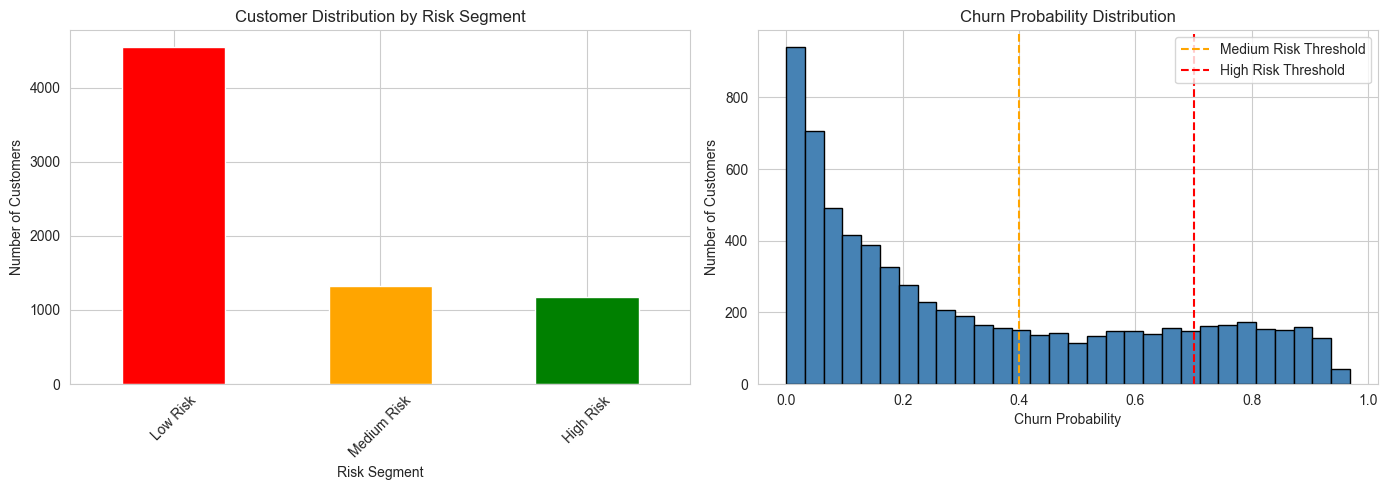

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


df_results['risk_segment'].value_counts().plot(kind='bar', ax=axes[0], 
    color=['red', 'orange', 'green'])
axes[0].set_title('Customer Distribution by Risk Segment')
axes[0].set_xlabel('Risk Segment')
axes[0].set_ylabel('Number of Customers')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


axes[1].hist(df_results['churn_probability'], bins=30, color='steelblue', edgecolor='black')
axes[1].axvline(0.4, color='orange', linestyle='--', label='Medium Risk Threshold')
axes[1].axvline(0.7, color='red', linestyle='--', label='High Risk Threshold')
axes[1].set_xlabel('Churn Probability')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Churn Probability Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [5]:
for segment in ['High Risk', 'Medium Risk', 'Low Risk']:
    segment_data = df_results[df_results['risk_segment'] == segment]
    
    print(f"\n{segment.upper()}")
    print(f"Customers: {len(segment_data):,} ({len(segment_data)/len(df_results)*100:.1f}%)")
    print(f"Avg churn probability: {segment_data['churn_probability'].mean():.1%}")
    
    if segment == 'High Risk':
        print("Strategy: Personal calls, 2x Bonga points, 30% contract discount, KES 1,000 cashback")
        print(f"Cost: KES {business_config['retention_cost_high_risk']:,}/customer")
        
    elif segment == 'Medium Risk':
        print("Strategy: SMS campaign, free data upgrade, network survey + KES 200 airtime")
        print(f"Cost: KES {business_config['retention_cost_medium_risk']:,}/customer")
        
    else:
        print("Strategy: Thank you SMS, 1GB bonus, upsell opportunities")
        print("Cost: Minimal")


HIGH RISK
Customers: 1,169 (16.6%)
Avg churn probability: 81.9%
Strategy: Personal calls, 2x Bonga points, 30% contract discount, KES 1,000 cashback
Cost: KES 500/customer

MEDIUM RISK
Customers: 1,328 (18.9%)
Avg churn probability: 55.3%
Strategy: SMS campaign, free data upgrade, network survey + KES 200 airtime
Cost: KES 200/customer

LOW RISK
Customers: 4,546 (64.5%)
Avg churn probability: 13.4%
Strategy: Thank you SMS, 1GB bonus, upsell opportunities
Cost: Minimal


In [6]:

clv = business_config['avg_customer_lifetime_value']
cost_high = business_config['retention_cost_high_risk']
cost_medium = business_config['retention_cost_medium_risk']
success_rate = business_config['retention_success_rate']

high_risk_customers = len(df_results[df_results['risk_segment'] == 'High Risk'])
medium_risk_customers = len(df_results[df_results['risk_segment'] == 'Medium Risk'])

revenue_saved_high = high_risk_customers * success_rate * clv
revenue_saved_medium = medium_risk_customers * success_rate * clv
total_revenue_saved = revenue_saved_high + revenue_saved_medium


total_cost_high = high_risk_customers * cost_high
total_cost_medium = medium_risk_customers * cost_medium
total_cost = total_cost_high + total_cost_medium


net_benefit = total_revenue_saved - total_cost
roi = (net_benefit / total_cost) * 100

print(f"At-Risk Customers: {high_risk_customers + medium_risk_customers:,} (High: {high_risk_customers:,}, Medium: {medium_risk_customers:,})")
print(f"\nCampaign Cost: KES {total_cost:,.0f}")
print(f"Revenue Saved: KES {total_revenue_saved:,.0f}")
print(f"Net Benefit: KES {net_benefit:,.0f}")
print(f"\nROI: {roi:.0f}%")
print(f"Payback: {(total_cost / (total_revenue_saved/12)):.1f} months")


At-Risk Customers: 2,497 (High: 1,169, Medium: 1,328)

Campaign Cost: KES 850,100
Revenue Saved: KES 4,994,000
Net Benefit: KES 4,143,900

ROI: 487%
Payback: 2.0 months


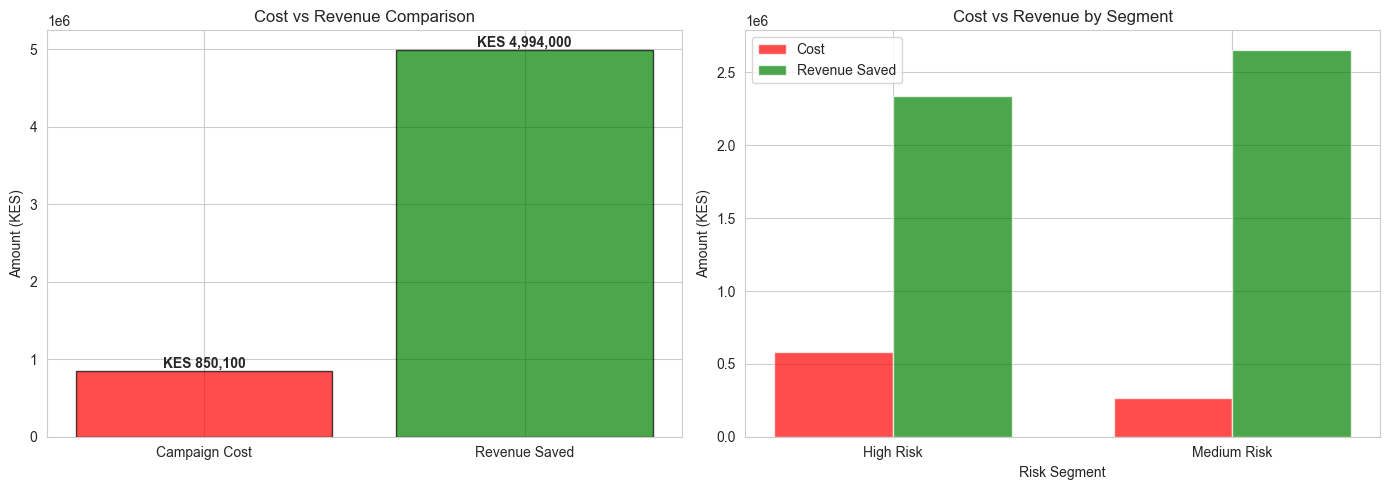

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost vs Revenue
categories = ['Campaign Cost', 'Revenue Saved']
values = [total_cost, total_revenue_saved]
colors = ['red', 'green']

axes[0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Amount (KES)')
axes[0].set_title('Cost vs Revenue Comparison')
for i, v in enumerate(values):
    axes[0].text(i, v, f'KES {v:,.0f}', ha='center', va='bottom', fontweight='bold')

# ROI breakdown 
segments = ['High Risk', 'Medium Risk']
costs = [total_cost_high, total_cost_medium]
revenues = [revenue_saved_high, revenue_saved_medium]

x = np.arange(len(segments))
width = 0.35

axes[1].bar(x - width/2, costs, width, label='Cost', color='red', alpha=0.7)
axes[1].bar(x + width/2, revenues, width, label='Revenue Saved', color='green', alpha=0.7)
axes[1].set_xlabel('Risk Segment')
axes[1].set_ylabel('Amount (KES)')
axes[1].set_title('Cost vs Revenue by Segment')
axes[1].set_xticks(x)
axes[1].set_xticklabels(segments)
axes[1].legend()

plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14480\3626928879.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data, labels=segments, patch_artist=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14480\3626928879.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data, labels=segments, patch_artist=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14480\3626928879.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data, labels=segments, patch_artist=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14480\3626928879.py:16: MatplotlibDeprecationWarni

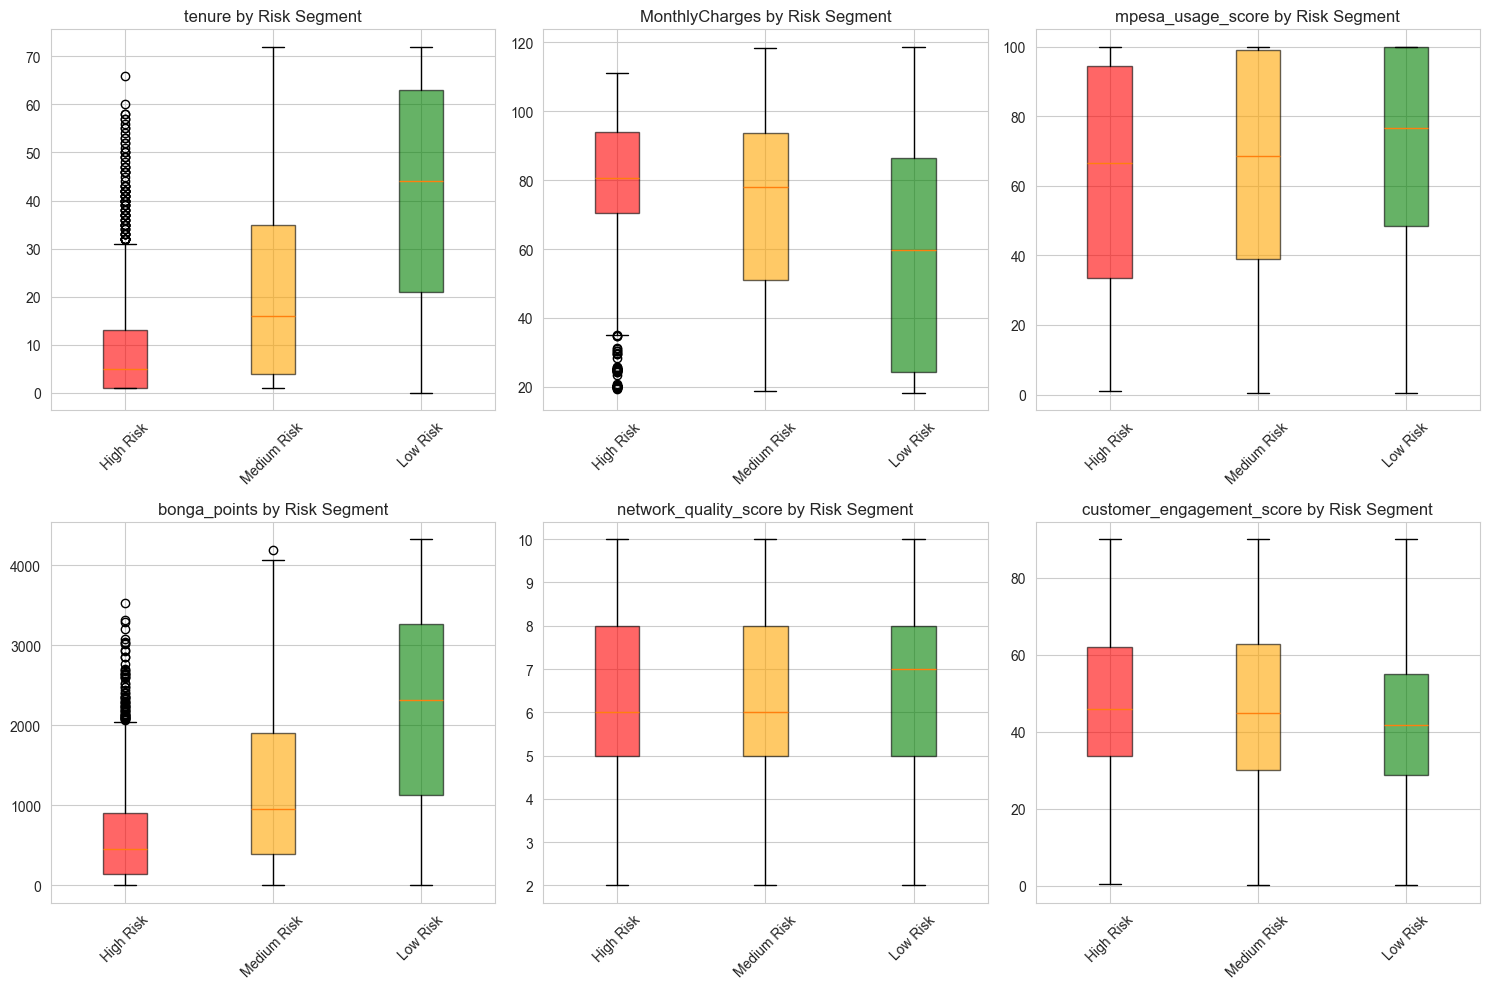

In [9]:

key_features = ['tenure', 'MonthlyCharges', 'mpesa_usage_score', 
                'bonga_points', 'network_quality_score', 'customer_engagement_score']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()


colors = {'High Risk': 'red', 'Medium Risk': 'orange', 'Low Risk': 'green'}

for i, feature in enumerate(key_features):
    
    segments = ['High Risk', 'Medium Risk', 'Low Risk']
    data = [df_results[df_results['risk_segment'] == seg][feature].values for seg in segments]
    
    
    bp = axes[i].boxplot(data, labels=segments, patch_artist=True)
    
    
    for patch, segment in zip(bp['boxes'], segments):
        patch.set_facecolor(colors[segment])
        patch.set_alpha(0.6)
    
    axes[i].set_title(f'{feature} by Risk Segment')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [10]:
high_risk = df_results[df_results['risk_segment'] == 'High Risk']

print(f"Avg Tenure: {high_risk['tenure'].mean():.1f} months")
print(f"Avg Monthly Charges: KES {high_risk['MonthlyCharges'].mean():.0f}")
print(f"M-Pesa Score: {high_risk['mpesa_usage_score'].mean():.1f}")
print(f"Bonga Points: {high_risk['bonga_points'].mean():.0f}")
print(f"Network Quality: {high_risk['network_quality_score'].mean():.1f}/10")
print(f"Engagement Score: {high_risk['customer_engagement_score'].mean():.0f}")

print(f"\nTop Contract Type: {high_risk['Contract'].value_counts().index[0]}")
print(f"Top Counties: {', '.join(high_risk['county'].value_counts().head(3).index.tolist())}")

Avg Tenure: 9.8 months
Avg Monthly Charges: KES 78
M-Pesa Score: 62.6
Bonga Points: 647
Network Quality: 6.2/10
Engagement Score: 47

Top Contract Type: Month-to-month
Top Counties: Nairobi, Mombasa, Nakuru
